In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
%pip install seaborn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

We have to use data provided by the client to address why their sales are failing. The data given includes User ID, Name, Gender, Age, Estimated Salary, and the status of their purchase (Purchased, Not Purchased, Returned). This project hopes to use the best of multiple models, such as Linear Regression and Logistic Regression, to predict the status of their purchase. The accuracy of this will be measured by just percent accurate or f1 score.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was given by the customer.

In [2]:
sale = pd.read_csv(Path("data/DanielC.csv"))
sale.head()

,User ID,name,Gender,Age,EstimatedSalary,Purchased
0,10000,Richard Scott,Male,31,99108,1
1,10001,Brenda Lee,Female,43,134673,1
2,10002,Brenda Garcia,Male,32,88682,1
3,10003,Amber Baker,Female,48,68404,0
4,10004,Paul Martinez,Male,26,108187,1


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [3]:
#Looking at the data and seeing the type and count
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          10001 non-null  int64 
 1   name             10001 non-null  object
 2   Gender           10001 non-null  object
 3   Age              10001 non-null  int64 
 4   EstimatedSalary  10001 non-null  int64 
 5   Purchased        10001 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


None of the data is missing. I believe User ID and name would be useless here. Name is randomly generated so we can't use any features of it here.

In [4]:
#looking at the values in the data
sale.head()

,User ID,name,Gender,Age,EstimatedSalary,Purchased
0,10000,Richard Scott,Male,31,99108,1
1,10001,Brenda Lee,Female,43,134673,1
2,10002,Brenda Garcia,Male,32,88682,1
3,10003,Amber Baker,Female,48,68404,0
4,10004,Paul Martinez,Male,26,108187,1


User ID and name are absolutely useless and we should get rid of them

In [5]:
sale["Gender"].value_counts()

Gender
Female    5060
Male      4941
Name: count, dtype: int64

There are 2 different genders and we should ordinal encode this

In [6]:
sale["Purchased"].value_counts()

Purchased
 0    5031
 1    4492
-1     478
Name: count, dtype: int64

For purchased there seems to be 3 different values. 0 means didn't buy. 1 means bought. -1 means returned. 

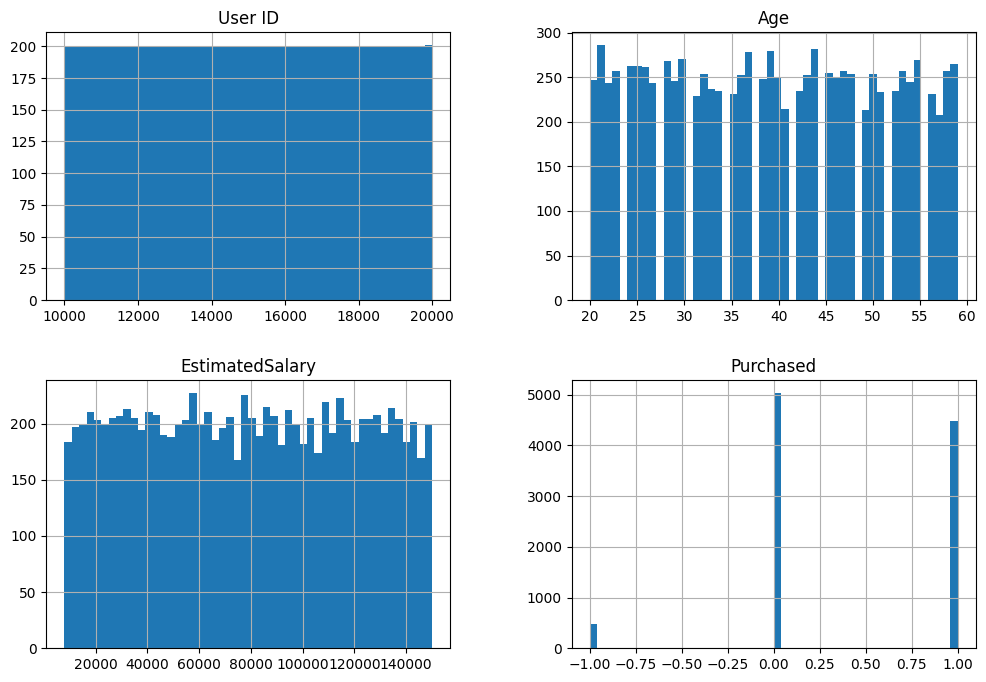

In [7]:
#Histogram for the numerical attributes
sale.hist(bins=50, figsize=(12,8))
plt.show()

The data seems roughly uniform with no skews

In [8]:
sale.describe()

,User ID,Age,EstimatedSalary,Purchased
count,10001.000000,10001.000000,10001.000000,10001.000000
mean,15000.000000,39.306869,78684.437856,0.401360
std,2887.184355,11.572913,40859.520317,0.579564
min,10000.000000,20.000000,8014.000000,-1.000000
25%,12500.000000,29.000000,42965.000000,0.000000
50%,15000.000000,39.000000,78624.000000,0.000000
75%,17500.000000,49.000000,114252.000000,1.000000
max,20000.000000,59.000000,149997.000000,1.000000


The mean/medians of age and estimated salary are roughly equivalent so there's no sign of skewness

In [9]:
#Looking at the correlations
corr_matrix = sale.corr(numeric_only = True)
corr_matrix["Purchased"].sort_values(ascending=False)

Purchased          1.000000
EstimatedSalary    0.009603
Age               -0.001100
User ID           -0.007665
Name: Purchased, dtype: float64

These all suck at correlating with Purchased

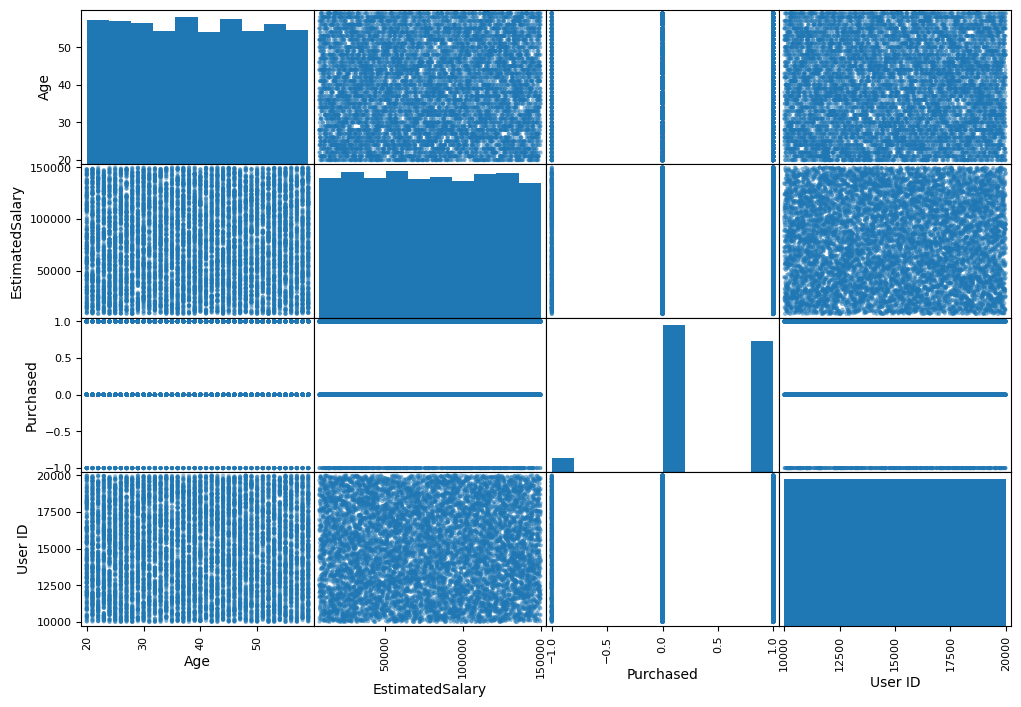

In [10]:
#scattermatrix
from pandas.plotting import scatter_matrix
attributes = ["Age","EstimatedSalary", "Purchased", "User ID"]
scatter_matrix(sale[attributes], figsize=(12,8))
plt.show()

not much can be extrapolated from this, there's not much correlation.
We should make new attributes using the current ones 

<Axes: >

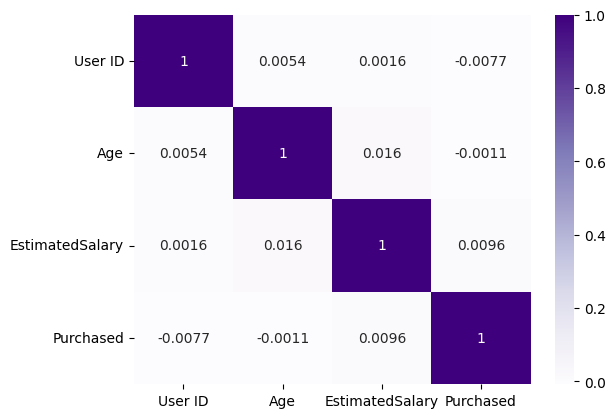

In [11]:
import seaborn as sb
  
sb.heatmap(corr_matrix, cmap="Purples", annot=True)

nice heat map

<Axes: >

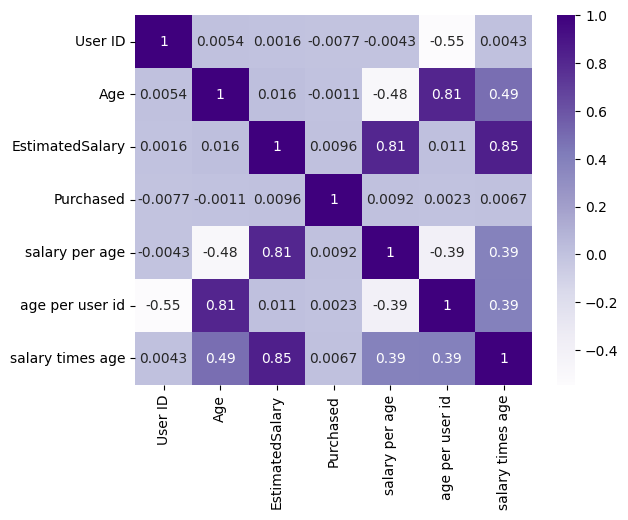

In [12]:
sales_copy = pd.read_csv(Path("data/DanielC.csv"))
sales_copy['salary per age'] = sales_copy['EstimatedSalary']/sales_copy['Age']
sales_copy['age per user id'] = sales_copy['Age']/sales_copy['User ID']
sales_copy['salary times age'] = sales_copy['EstimatedSalary']*sales_copy['Age']

corr_matrixc = sales_copy.corr(numeric_only = True)
corr_matrixc["Purchased"].sort_values(ascending=False)
sb.heatmap(corr_matrixc, cmap="Purples", annot=True)

There's not much relationship improvement. Perhaps there's some hidden correlation that's not linear.

Summary:\
(x)Scaling the data\
(x)Ordinal encode Gender\
(x)Remove unnecessary data


# 4.Prepare the Data


Apply any data transformations and explain what and why


In [13]:
#we are now removing User ID
sale.drop(['User ID'], axis=1, inplace=True)
sale.head()

,name,Gender,Age,EstimatedSalary,Purchased
0,Richard Scott,Male,31,99108,1
1,Brenda Lee,Female,43,134673,1
2,Brenda Garcia,Male,32,88682,1
3,Amber Baker,Female,48,68404,0
4,Paul Martinez,Male,26,108187,1


In [14]:
#we are now removing User ID
sale.drop(['name'], axis=1, inplace=True)
sale.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,31,99108,1
1,Female,43,134673,1
2,Male,32,88682,1
3,Female,48,68404,0
4,Male,26,108187,1


In [15]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
sale['Gender'] = ordinal_encoder.fit_transform(sale[['Gender']])
sale["Gender"].value_counts()

Gender
0.0    5060
1.0    4941
Name: count, dtype: int64

0 is female and 1 is male!

In [16]:
#scaling the data
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
sale[['Age']] = std_scaler.fit_transform(sale[['Age']])
sale[['EstimatedSalary']] = std_scaler.fit_transform(sale[['EstimatedSalary']])

In [17]:
sale.describe()

,Gender,Age,EstimatedSalary,Purchased
count,10001.000000,1.000100e+04,1.000100e+04,10001.000000
mean,0.494051,-1.863212e-16,-1.044393e-16,0.401360
std,0.499990,1.000050e+00,1.000050e+00,0.579564
min,0.000000,-1.668364e+00,-1.729682e+00,-1.000000
25%,0.000000,-8.906474e-01,-8.742448e-01,0.000000
50%,0.000000,-2.651749e-02,-1.479236e-03,0.000000
75%,1.000000,8.376124e-01,8.705276e-01,1.000000
max,1.000000,1.701742e+00,1.745398e+00,1.000000


The data is scaled and gender is ordinally encoded!

Time to take a second look at the data!

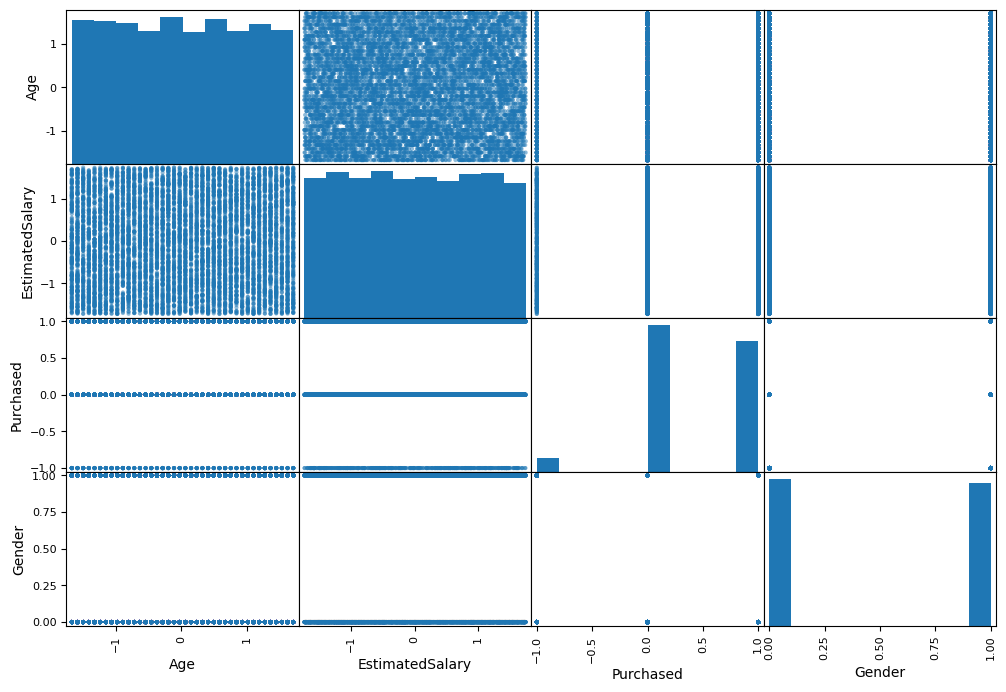

In [18]:
attributes = ["Age","EstimatedSalary", "Purchased","Gender"]
scatter_matrix(sale[attributes], figsize=(12,8))
plt.show()

In [19]:
corr_matrix = sale.corr(numeric_only = True)
corr_matrix["Purchased"].sort_values(ascending=False)

Purchased          1.000000
EstimatedSalary    0.009603
Gender             0.006516
Age               -0.001100
Name: Purchased, dtype: float64

Currently Estimated Salary has the highest correlation, with gender close behind. Age still sucks though.

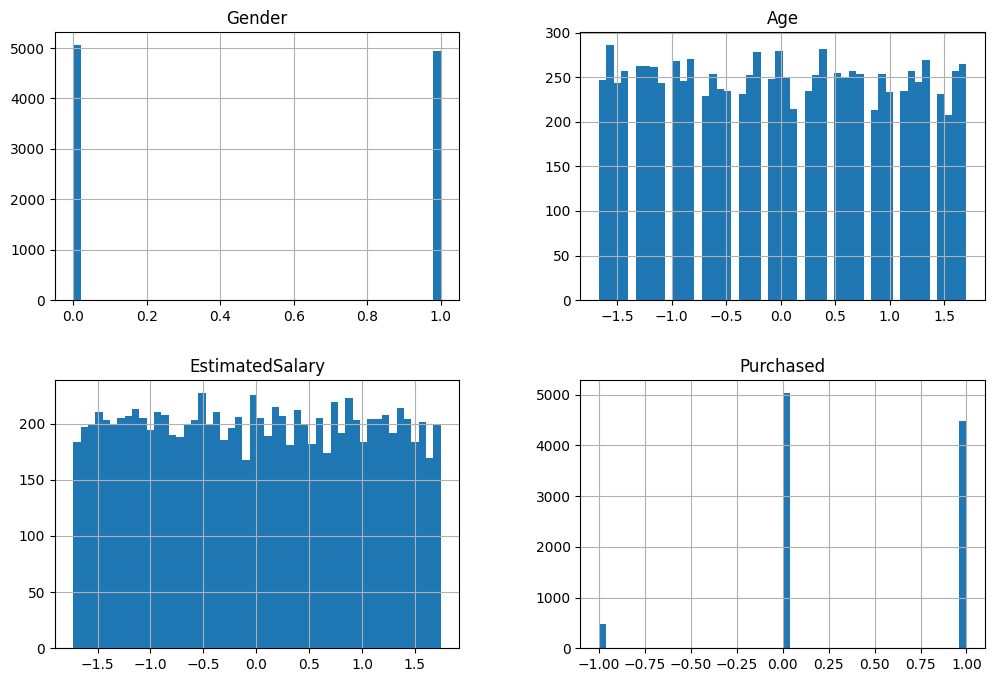

In [20]:
sale.hist(bins=50, figsize=(12,8))
plt.show()

In [21]:
#pipeline creations
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_attributes = ['Age','EstimatedSalary']



num_pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])



full_pipeline = ColumnTransformer([
    ('gender', OrdinalEncoder(), ['Gender']),
    ('num', num_pipeline, num_attributes),

    
])
salecopy = pd.read_csv(Path("data/DanielC.csv"))
full_pipeline.fit_transform(salecopy.drop("Purchased", axis=1))


#This pipeline is for future use as I have already prepared the data 

array([[ 1.        , -0.71782139,  0.4998733 ],
       [ 0.        ,  0.31913445,  1.3703382 ],
       [ 1.        , -0.6314084 ,  0.24469357],
       ...,
       [ 1.        , -1.49553826, -0.76261286],
       [ 0.        ,  0.75119938, -0.15075424],
       [ 1.        ,  0.05989549,  0.40131117]])

Time to split the data

In [22]:
#training set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sale, test_size=0.2,  random_state=42)
sale_x = train_set.drop("Purchased", axis=1)
sale_labels = train_set["Purchased"].copy()

test_x = test_set.drop("Purchased", axis=1)
test_labels = test_set["Purchased"].copy()

In [23]:
sale_x.head()

,Gender,Age,EstimatedSalary
1561,0.0,-0.804234,1.575857
1670,0.0,-0.890647,0.224257
6087,1.0,0.491960,-0.428084
6669,0.0,1.528916,-0.751868
5933,1.0,-1.409125,-1.359028


The pipeline is made and the data is split! Time to pick a model and see how it performs

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


I want to see how a basic linear regression performs here

In [24]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(sale_x, sale_labels)

LinearRegression()

In [25]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
sale_pred = lin_reg.predict(sale_x)

lin_rmse = root_mean_squared_error(sale_labels, sale_pred)
lin_ras = mean_absolute_error(sale_labels, sale_pred)
lin_r2 = r2_score(sale_labels, sale_pred)

print("rmse: " + str(lin_rmse) + "\nRAS: " + str(lin_ras) + "\nR^2: " + str(lin_r2))

rmse: 0.5812996325342344
RAS: 0.5384334962557593
R^2: 0.00011388510668841612


In [26]:
sale_pred[:5]


array([0.40501287, 0.3972782 , 0.39862576, 0.39200972, 0.39306278])

Absolutely terrible, I wonder if the score will improve if I round the numbers.

In [27]:
sale_pred2 = sale_pred.round()
sale_pred2[:5]

array([0., 0., 0., 0., 0.])

In [28]:
lin_rmse2 = root_mean_squared_error(sale_labels, sale_pred2)
lin_ras2 = mean_absolute_error(sale_labels, sale_pred2)
lin_r22 = r2_score(sale_labels, sale_pred2)

print("rmse: " + str(lin_rmse2) + "\nRAS: " + str(lin_ras2) + "\nR^2: " + str(lin_r22))

rmse: 0.7048049375536468
RAS: 0.49675
R^2: -0.4699017821541942


RMSE worsened, RAS improved, and R^2 also improved. Note: must round values after\
Let's check accuracy

In [29]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(sale_labels,sale_pred2)
print(accuracy)


0.50325


In [ ]:
sale_labels

50% accurate \
Better than guessing random values, but not good

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier(n_estimators = 100) 

randfor.fit(sale_x, sale_labels)


randforscore = cross_val_score(randfor, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(randforscore).describe()



count    20.000000
mean      0.465626
std       0.027237
min       0.404914
25%       0.448598
50%       0.467726
75%       0.488203
max       0.498941
dtype: float64

In [31]:
sale_pred_for = randfor.predict(sale_x)


In [32]:
accuracy = accuracy_score(sale_labels,sale_pred_for)
print(accuracy)

0.999625


that's a pretty good accuracy score, this is probably ovefitting

let's see how KNN classifier performs

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knnc = KNeighborsClassifier()
knnc.fit(sale_x,sale_labels)

KNeighborsClassifier()

In [34]:
sale_pred_knn = knnc.predict(sale_x)
accuracy_knn = accuracy_score(sale_labels,sale_pred_knn)
print(accuracy_knn)


0.65775


not that good of accuracy

In [35]:
knncscore = cross_val_score(knnc, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(knncscore).describe()

count    20.000000
mean      0.470412
std       0.022471
min       0.430940
25%       0.457662
50%       0.469939
75%       0.476766
max       0.538679
dtype: float64

better f score than random forest but the accuracy isn't good.

In [36]:
from sklearn.svm import SVC

svmc = SVC(random_state=42)
svmc.fit(sale_x,sale_labels)

SVC(random_state=42)

In [37]:
sale_pred_svc = svmc.predict(sale_x)
accuracy_svc = accuracy_score(sale_labels,sale_pred_svc)
print(accuracy_svc)

0.50325


In [38]:
svcscore = cross_val_score(svmc, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(svcscore).describe()

count    20.000000
mean      0.338747
std       0.004093
min       0.335000
25%       0.336115
50%       0.337161
75%       0.338904
max       0.351003
dtype: float64

worse than the previous ones in both accuracy and f1 score

In [39]:
from sklearn.tree import DecisionTreeClassifier
treec = DecisionTreeClassifier()
treec.fit(sale_x,sale_labels)

DecisionTreeClassifier()

In [40]:
sale_pred_dtc = treec.predict(sale_x)
accuracy_dtc = accuracy_score(sale_labels,sale_pred_dtc)
print(accuracy_dtc)

0.99975


extremely high accuracy score, probably overfitting

In [41]:
dtcscore = cross_val_score(treec, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(dtcscore).describe()

count    20.000000
mean      0.449026
std       0.026631
min       0.393413
25%       0.432664
50%       0.443685
75%       0.472722
max       0.496572
dtype: float64

The f1 score isn't the best, so it's probably overfitting

I think I will use random forest regressor and see if i can improve it

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best results possiable 


In [42]:
#time to randomized serach to fine tne the parameters!
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint



param_distribs = {'n_estimators': randint(low=1,high=100),
               'max_depth': randint(low=10,high=110),
               'min_samples_split': randint(low=2,high=100),
               'min_samples_leaf': randint(low=1,high=100),
               'bootstrap': [True, False]}


In [43]:
#100 iterations
rnd_search = RandomizedSearchCV(randfor, param_distributions = param_distribs, n_iter=100, cv = 3, scoring = 'f1_weighted', random_state=42)
rnd_search.fit(sale_x,sale_labels)

model_f = rnd_search.best_estimator_

rnd_search.best_params_

{'bootstrap': True,
 'max_depth': 81,
 'min_samples_leaf': 12,
 'min_samples_split': 35,
 'n_estimators': 33}

In [44]:
model_f_pred = model_f.predict(sale_x)


accuracy_fp = accuracy_score(sale_labels,model_f_pred)
print(accuracy_fp)
fpscore = cross_val_score(model_f, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(fpscore).describe()

0.63425


count    20.000000
mean      0.473211
std       0.027391
min       0.424760
25%       0.457011
50%       0.475050
75%       0.487194
max       0.523436
dtype: float64

accuracy decreased but the f1 score increased (makes sense since we're finding ones with the highest f1 score)
Let's see if i can make this better with more iterations

In [45]:
#1000 iterations
rnd_search2 = RandomizedSearchCV(randfor, param_distributions = param_distribs, n_iter=1000, cv = 3, scoring = 'f1_weighted', random_state=42)
rnd_search2.fit(sale_x,sale_labels)

model_f2 = rnd_search2.best_estimator_

rnd_search2.best_params_

/opt/tljh/user/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'bootstrap': False,
 'max_depth': 108,
 'min_samples_leaf': 7,
 'min_samples_split': 28,
 'n_estimators': 92}

In [46]:
model_f_pred2 = model_f2.predict(sale_x)


accuracy_fp2 = accuracy_score(sale_labels,model_f_pred2)
print(accuracy_fp2)
fpscore2 = cross_val_score(model_f2, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(fpscore2).describe()

0.712625


count    20.000000
mean      0.472590
std       0.022810
min       0.429125
25%       0.460322
50%       0.473025
75%       0.483709
max       0.509136
dtype: float64

worse than before

In [ ]:
#10000 iterations
rnd_search3 = RandomizedSearchCV(randfor, param_distributions = param_distribs, n_iter=10000, cv = 3, scoring = 'f1_weighted', random_state=42)
rnd_search3.fit(sale_x,sale_labels)

model_f3 = rnd_search3.best_estimator_

rnd_search3.best_params_

In [ ]:
model_f_pred3 = model_f3.predict(sale_x)


accuracy_fp3 = accuracy_score(sale_labels,model_f_pred3)
print(accuracy_fp3)
fpscore3 = cross_val_score(model_f3, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(fpscore3).describe()

This seems to not be as good. The accuracy isn't the highest, but the f1 score is the highest of them all. The accuracy for the 100 iteration one is higher with minimal f1 score difference. I will use that one

In [ ]:
#seeing if combining accuracy and f1 would improve anything
rnd_search4 = RandomizedSearchCV(randfor, param_distributions = param_distribs, n_iter=100, cv = 3, scoring = ['f1_weighted','accuracy'], random_state=42, refit='accuracy')
rnd_search4.fit(sale_x,sale_labels)

model_f4 = rnd_search4.best_estimator_

rnd_search4.best_params_

In [ ]:
model_f_pred4 = model_f4.predict(sale_x)


accuracy_fp4 = accuracy_score(sale_labels,model_f_pred4)
print(accuracy_fp4)
fpscore4 = cross_val_score(model_f4, sale_x, sale_labels, scoring="f1_weighted", cv =20)
pd.Series(fpscore4).describe()

no noticeable improvement.

In [ ]:
final_pred = model_f.predict(test_x)
final_accuracy = accuracy_score(test_labels, final_pred)
print(final_accuracy)

49% isn't that bad. It's ~20% lower than the train set accuracy :C

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


### The problem
The problem that I was given is to figure out why a certain company is losing sales. To do this I must create a model that predicts whether a customer will purchase, not purchase, or return the certain product given their name, gender, age, and estimated salary. We aim to use multiple different models to find the best given their f1 and accuracy score. 
### Getting the data
The data was obtained from the customer regarding their recent customers.
### Exploring the data
While exploring the data, I noticed that the data was complete and wasn’t missing any data points. The attributes for User ID and Name were useless, since User ID is just how the people are ordered and the names of the people are randomly generated. Gender has two different values, male or female, which must be encoded. The other numerical attributes seemed uniformly distributed, so only scaling is needed for these. Purchased has 3 possible values, 1,0,-1, which represent bought, didn’t buy, and returned respectively. I noticed that the correlation between these attributes and Purchased is very low. 
### Preparing the data
I first dropped the unnecessary data (User ID and Name). Then, I ordinal encoded Gender such that 0 is female and 1 is male. After, I standard scaled the numerical attributes (Age and Estimated Salary). I then created a pipeline that did all of this to prepare the inputs of the model. I re-explored the data and noticed that not much changed except for the fact that Gender had the second highest correlation.
### Modeling the data
I decided to first start off with Linear Regression to see how the model would perform. It didn’t perform well at first, but I believe that was because I didn’t round the output.values. This edited version performs decently well, but not the best (50% accuracy). I decided to use a Random Forest Classifier to see if it would perform well and it managed to get a very high accuracy. I then cross validated using f1 score and noticed that it didn’t do the best. As a result, I tested a KNN classifier, thought its accuracy score was worse, but it’s f1 score was slightly better. I also decided to test SVC and Decision Tree Classifier, but SVC performed worse than everything and Decision Tree Classifier performed similar to Random Forest, but the cross validation score was lower. I decided to use the Random Forest Classifier in the end and see if I can improve it.
### Fine tune the model
I decided to use Randomized Search CV to tune the hyperparameters of the model. I started off with 100 iterations and then scaled up to 10,000. I decided to use f1 score as a scoring metric for the searches. This resulted in the accuracy decreasing, but the f1 score slightly increasing. I decided in the end to use the first one with the higher f1 score and accuracy. I then combined it with the pipeline and saved the model.

### Possible Bias
Since I didn't stratify split the test and train data, there may be some bias against the people that return the items, since the amount of people that returned the item is relatively small compared to the bought and not bought people. Otherwise, since the data is unfiormly distributed, there's not much other issues.



In [ ]:
lin_reg.coef_

Since this is gender, age, then estimated salary, this shows that estimated salary and gender seemed to have a greater impact on wherther or not a customer bought this item, while age has a smaller effect. This implys that males and people with higher salaries are more likely to buy this item, with older people slighty likelier to buy it. 

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
import joblib
from sklearn.pipeline import make_pipeline 

new_model = make_pipeline(full_pipeline,
                          model_f)
joblib.dump(new_model, "SalePredictionModel.pkl")

In [ ]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def infrence(prams):
    df = {"Gender": [prams[2]],"Age": [prams[3]],"EstimatedSalary": [prams[4]]}
    newparams = pd.DataFrame(data=df)
    m = joblib.load("SalePredictionModel.pkl")
    results = m.predict(newparams)[0]
    return results 
#Parameter order: User ID, name, gender, age, estimated salary
print(infrence([10001,"Brenda Lee","Female",43,134673]))

The actual value is 1. Not bad.